In [11]:
import MDAnalysis as mda
import numpy as np
from MDAnalysis.analysis.msd import EinsteinMSD
import os
import numpy as np
import MDAnalysis as mda

dirs = [
    "13-0_test-d-4_lim_in-lmp/",
    "14-0_test-d-5_lim_in-lmp/",
    "15-0_test-d-6_lim_in-lmp/",
    "16-0_test-d-7_lim_in-lmp/",
]

# path1 = '/raid/hwding/gpumd/gpumd_dynamic/test4/fix/fix-C/'
path1 =  '/raid/hwding/gpumd/gpumd_dynamic/test6/5ns/' + dirs[0] 
print(path1)
file1 = path1 + "properties.xyz"


/raid/hwding/gpumd/gpumd_dynamic/test6/5ns/13-0_test-d-4_lim_in-lmp/


In [12]:
def write_msd_xyz(infile="properties.xyz", outfile="msd.xyz", encoding="utf-8"):
    """
    读取扩展XYZ(properties.xyz)：
      a) 按每帧: 第1行n_atoms, 第2行comment, 接着n_atoms行原子数据；先统计并输出总帧数
      b) 对每个原子行：保留第1列symbol + 第13-15列(unwrapped_position) 作为新的 x y z
      c) 每帧写入：原来的前两行 + 提取后的原子行 到 msd.xyz（与输入文件同目录）
    """
    import os

    # 让输出文件位于与输入文件相同的文件夹
    outfile = os.path.join(os.path.dirname(os.path.abspath(infile)), outfile)

    # pass 1: count frames
    nframes = 0
    with open(infile, "r", encoding=encoding) as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.strip()
            if not line:
                continue
            try:
                n = int(line)
            except ValueError as e:
                raise ValueError(f"Frame header (n_atoms) parse failed at frame {nframes+1}: {line}") from e
            _comment = f.readline()
            if not _comment:
                raise EOFError(f"Unexpected EOF after n_atoms line in frame {nframes+1}")
            for _ in range(n):
                atom_line = f.readline()
                if not atom_line:
                    raise EOFError(f"Unexpected EOF in atom lines of frame {nframes+1}")
            nframes += 1

    print(nframes)

    # pass 2: write msd.xyz
    with open(infile, "r", encoding=encoding) as fin, open(outfile, "w", encoding=encoding) as fout:
        for _ in range(nframes):
            n_line = fin.readline()
            while n_line and not n_line.strip():
                n_line = fin.readline()
            if not n_line:
                break
            n = int(n_line.strip())
            comment = fin.readline()
            fout.write(f"{n}\n")
            fout.write(comment if comment.endswith("\n") else comment + "\n")

            for _ in range(n):
                parts = fin.readline().split()
                if len(parts) < 15:
                    raise ValueError(f"Atom line has <15 columns, cannot read unwrapped_position: {' '.join(parts)}")
                sym = parts[0]
                x, y, z = parts[12], parts[13], parts[14]  # 1-based 13-15
                fout.write(f"{sym} {x} {y} {z}\n")

    return outfile

if __name__ == "__main__":
    write_msd_xyz(infile=file1, outfile="msd_OH.xyz")


1000


In [13]:
import os
import numpy as np
import MDAnalysis as mda

def write_O_relative_to_COM_xyz(file2, out_name="com_O.xyz", selection="name O", fmt="{:.8f}"):


    """
    读取多帧XYZ(file2)，每帧计算所选O原子组的COM，并将每个O原子坐标平移到相对COM坐标系：
      - 输出XYZ每帧第1行：O原子数
      - 第2行：保持原文件该帧的comment/lattice行不变
      - 后续：O x y z（相对COM）

    Returns: (out_file, n_frames, nO)
    """
    # 1) 读入Universe并选择O
    u = mda.Universe(file2)
    agO = u.select_atoms(selection)
    nO = agO.n_atoms
    if nO == 0:
        raise ValueError(f"选择 '{selection}' 得到0个原子，请检查元素符号/字段（如 O vs OW）。")

    # 2) 预读每帧第二行(comment/lattice)并统计帧数（按原始xyz文本）
    comments = []
    with open(file2, "r") as f:
        while True:
            line1 = f.readline()
            if not line1:
                break
            try:
                n = int(line1.strip().split()[0])
            except Exception:
                raise ValueError(f"XYZ格式错误：无法解析原子数行：{line1!r}")
            comment = f.readline()
            if comment == "":
                raise ValueError("XYZ格式错误：缺少第二行comment/lattice行")
            comments.append(comment.rstrip("\n"))
            for _ in range(n):
                if f.readline() == "":
                    raise ValueError("XYZ格式错误：原子行不完整（提前EOF）")

    n_frames = len(comments)

    # 3) 输出文件路径（与输入同目录）
    out_file = os.path.join(os.path.dirname(file2), out_name)

    # 4) 逐帧写出：O相对COM坐标
    with open(out_file, "w") as out:
        for ts in u.trajectory:
            com = agO.center_of_mass()
            rel = agO.positions - com  # (nO, 3)

            out.write(f"{nO}\n")
            out.write(comments[ts.frame] + "\n")
            for x, y, z in rel:
                out.write(f"O {fmt.format(x)} {fmt.format(y)} {fmt.format(z)}\n")

    return out_file, n_frames, nO


file2 = path1 + "msd_OH.xyz"

out_file, n_frames, nO = write_O_relative_to_COM_xyz(file2=file2, out_name="com_O.xyz", selection="name O", fmt="{:.8f}")

In [ ]:

file3 =  path1+ "com_O.xyz"
u = mda.Universe(file3)
ag = u.select_atoms("name O")
# for ts in u.trajectory:
#     z = ag.positions[0, 2]   # 每帧第一个O原子的z
#     print(ts.frame, ts.time, z)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from MDAnalysis.analysis.msd import EinsteinMSD

run_in = path1 + "run_in"


In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from MDAnalysis.analysis.msd import EinsteinMSD

# ========= 0) 从 run_in 自动提取 dt_fs / T_high / T_low =========
run_in = path1 + "run.in"

dump_thermo_steps = None
T_high = None
T_low = None

with open(run_in, "r", encoding="utf-8") as f:
    for raw in f:
        line = raw.strip()
        if not line or line.startswith("#"):
            continue

        # 1) dump_thermo 5000  -> 取第二列 5000 （按你要求当作 dt_fs）
        if line.split()[0] == "dump_thermo" and dump_thermo_steps is None:
            dump_thermo_steps = int(line.split()[1])

        # 2) ensemble nvt_nhc 300 250 100 -> 取第3、第4列温度
        if line.split()[0] == "ensemble" and T_high is None and T_low is None:
            parts = line.split()
            T_high = float(parts[2])
            T_low = float(parts[3])

if dump_thermo_steps is None:
    raise ValueError("run_in 中未找到 'dump_thermo' 行，无法提取第二列。")
if T_high is None or T_low is None:
    raise ValueError("run_in 中未找到 'ensemble' 行，无法提取第3/4列温度。")
print(f"Extracted from run_in: dt_fs={dump_thermo_steps}, T_high={T_high}, T_low={T_low}")

Extracted from run_in: dt_fs=5000, T_high=300.0, T_low=250.0


100%|██████████| 99/99 [00:00<00:00, 37338.02it/s]


T=300K  frames[0:100]  slope=1.3733 Å^2/ns  Dz=0.686651 Å^2/ns = 6.86651e-08 cm^2/s  r=0.6996


100%|██████████| 199/199 [00:00<00:00, 28584.47it/s]

T=290K  frames[100:300]  slope=0.00244964 Å^2/ns  Dz=0.00122482 Å^2/ns = 1.22482e-10 cm^2/s  r=0.0621


100%|██████████| 199/199 [00:00<00:00, 29618.06it/s]


T=280K  frames[300:500]  slope=0.0185698 Å^2/ns  Dz=0.0092849 Å^2/ns = 9.2849e-10 cm^2/s  r=0.2940


100%|██████████| 199/199 [00:00<00:00, 29840.42it/s]


T=270K  frames[500:700]  slope=0.0176217 Å^2/ns  Dz=0.00881086 Å^2/ns = 8.81086e-10 cm^2/s  r=0.3829


100%|██████████| 199/199 [00:00<00:00, 30507.93it/s]


T=260K  frames[700:900]  slope=0.00423259 Å^2/ns  Dz=0.00211629 Å^2/ns = 2.11629e-10 cm^2/s  r=0.1232


100%|██████████| 99/99 [00:00<00:00, 39907.36it/s]


T=250K  frames[900:1000]  slope=0.0464877 Å^2/ns  Dz=0.0232439 Å^2/ns = 2.32439e-09 cm^2/s  r=0.4169


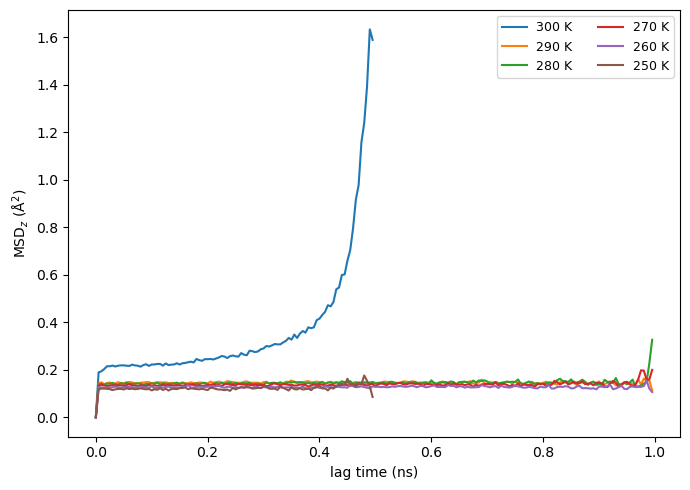

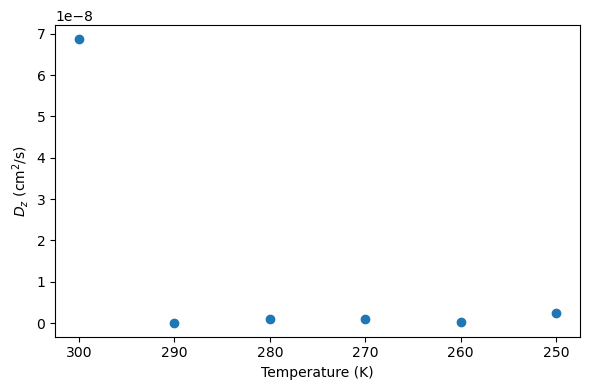

In [20]:
dt_fs = dump_thermo_steps          # 按你的要求：把dump_thermo第二列作为dt_fs
dt_ns = dt_fs / 1_000_000.0        # fs -> ns

# ========= 1) 你已有：u, ag =========
n_total = len(u.trajectory)

# 3) t2_ns 用总时长
t1_ns = 0.0
t2_ns = n_total * dt_ns

# 4) 温度间隔数 n = (T_high - T_low)/10
n_intervals = int(round((T_high - T_low) / 10.0))
if n_intervals <= 0:
    raise ValueError(f"温度范围不合法：T_high={T_high}, T_low={T_low}")

# 温度序列：T_high, T_high-10, ..., T_low
temps = np.arange(T_high, T_low - 1e-9, -10.0)
# print("t2_ns:", t2_ns, "Temperatures for MSD analysis:", temps)
# 5) m = 总帧数 / 间隔数（每10K对应的帧数）
m = int(round(n_total / n_intervals))
half = m // 2
if half < 1:
    raise ValueError(f"窗口太小：m={m}, half={half}。请检查帧数或温度范围。")

# print(f"Total frames: {n_total}, Intervals: {n_intervals}, Frames per interval (m): {m}, half: {half}")
def window_for_index(k):
    """k=0 对应最高温，k=n_intervals 对应最低温；中间点用中心±m/2。"""
    if k == 0:
        return 0, min(n_total, half)
    if k == n_intervals:
        return max(0, n_total - half), n_total
    center = k * m
    start = max(0, center - half)
    stop = min(n_total, center + half)
    return start, stop

Dz_list_cm2s = []
msd_curves = {}  # T -> (lag_ns, msd_z)

for k, T in enumerate(temps):
    start, stop = window_for_index(k)

    MSDz = EinsteinMSD(ag, msd_type="z", fft=False)
    MSDz.run(start=start, stop=stop)

    msd_z = MSDz.results.timeseries           # Å^2
    nframes = MSDz.n_frames
    lag_ns = np.arange(nframes) * dt_ns       # ns
    msd_curves[T] = (lag_ns, msd_z)

    # 拟合扩散系数（用整段 0~t2_ns；若你想跳过ballistic段，可把t1_ns调大）
    i1 = int(t1_ns / dt_ns)
    i2 = int(t2_ns / dt_ns)
    i1 = max(0, min(i1, nframes - 2))
    i2 = max(i1 + 2, min(i2, nframes))

    fit = linregress(lag_ns[i1:i2], msd_z[i1:i2])
    slope = fit.slope  # Å^2/ns

    # 1D：<Δz^2> = 2 D t => D = slope/2
    Dz_A2ns = slope / 2.0
    Dz_cm2s = Dz_A2ns * 1e-7  # 1 Å^2/ns = 1e-7 cm^2/s
    Dz_list_cm2s.append(Dz_cm2s)

    print(f"T={T:.0f}K  frames[{start}:{stop}]  slope={slope:.6g} Å^2/ns  Dz={Dz_A2ns:.6g} Å^2/ns = {Dz_cm2s:.6g} cm^2/s  r={fit.rvalue:.4f}")

# (4) 每个温度的 MSDz(t) 曲线
plt.figure(figsize=(7, 5))
for T in temps:
    lag_ns, msd_z = msd_curves[T]
    plt.plot(lag_ns, msd_z, label=f"{T:.0f} K")
plt.xlabel("lag time (ns)")
plt.ylabel(r"MSD$_z$ ($\mathrm{\AA}^2$)")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# (6) 温度-扩散系数散点图
plt.figure(figsize=(6, 4))
plt.scatter(temps, Dz_list_cm2s)
plt.xlabel("Temperature (K)")
plt.ylabel(r"$D_z$ (cm$^2$/s)")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()